# Validation results

In this notebook we examine how well Oxford Nanopore SNP calling agrees with SNP calling from Illumina data.

The parameters we use are:
    * nanopolish: 5-mer alignment, 6-mer variant calling, reverse HMM fix

In [6]:
ROOTDIR="/mnt/ebola/ebov"
import os
os.environ['PATH'] = os.getenv('PATH') + ':' + ROOTDIR + '/scripts'

In [7]:
%cd $ROOTDIR

/mnt/ebola/ebov


In [8]:
%%bash

ROOTDIR="/mnt/ebola/ebov"
cd $ROOTDIR
export PATH=`pwd`/bin/bwa:$PATH
export PATH=$PATH:`pwd`/scripts
export PATH=$PATH:`pwd`/bin/nanopolish-6mer
export PATH=$PATH:`pwd`/bin/samtools
export PATH=$PATH:`pwd`/bin/marginAlign

mkdir -p 180genomes-validation
cd 180genomes-validation

echo "../models/6mer/ont_complement.pop1.model" > offset_models.fofn
echo "../models/6mer/ont_complement.pop2.model" >> offset_models.fofn
echo "../models/6mer/ont_template.model" >> offset_models.fofn

makecommands.py ../metadata/metadata.db 180_Genomes align_defaultkmer_margin.sh | parallel -j16

reading ../models/6mer/ont_complement.pop1.model
reading ../models/6mer/ont_complement.pop2.model
reading ../models/6mer/ont_template.model
reading ../models/6mer/ont_complement.pop1.model
reading ../models/6mer/ont_complement.pop2.model
reading ../models/6mer/ont_template.model
reading ../models/6mer/ont_complement.pop1.model
reading ../models/6mer/ont_complement.pop2.model
reading ../models/6mer/ont_template.model
reading ../models/6mer/ont_complement.pop1.model
reading ../models/6mer/ont_complement.pop2.model
reading ../models/6mer/ont_template.model
reading ../models/6mer/ont_complement.pop1.model
reading ../models/6mer/ont_complement.pop2.model
reading ../models/6mer/ont_template.model
reading ../models/6mer/ont_complement.pop1.model
reading ../models/6mer/ont_complement.pop2.model
reading ../models/6mer/ont_template.model
reading ../models/6mer/ont_complement.pop1.model
reading ../models/6mer/ont_complement.pop2.model
reading ../models/6mer/ont_template.model
reading ../models/6m

+ ref_prefix=EM_079517
+ sample=076383_180Genomes_11rx
+ poretools_dir=076383_180Genomes_11rx
+ sample_tag=076383_180Genomes_11rx_hq
+ second_batch=na
+ read_type=hq
++ tempfile
+ tmp=/tmp/fileNIZFVX
+ poretools fastq --type 2D ../data/076383_180Genomes_11rx/pass
+ poretools fasta --type 2D ../data/076383_180Genomes_11rx/pass
+ '[' hq == hq ']'
+ poretools fastq --type 2D --high-quality ../data/076383_180Genomes_11rx/fail
+ poretools fasta --type 2D --high-quality ../data/076383_180Genomes_11rx/fail
+ '[' '!' na == na ']'
+ mv /tmp/fileNIZFVX 076383_180Genomes_11rx_hq.fastq
+ mv /tmp/fileNIZFVX.fasta 076383_180Genomes_11rx_hq.fasta
+ '[' '!' -e ../refs/EM_079517.fasta.amb ']'
+ rm -rf jobTree_align_EM_079517_076383_180Genomes_11rx_hq
+ marginAlign 076383_180Genomes_11rx_hq.fastq ../refs/EM_079517.fasta EM_079517_076383_180Genomes_11rx_hq.sam --jobTree jobTree_align_EM_079517_076383_180Genomes_11rx_hq --inputModel ../models/input_10_04.hmm
Got message from job at time: 1446200766.47 : G

In [3]:
## After the raw files are produced, show statistics.

%cd 180genomes-validation

/mnt/ebola/ebov/analysis-var6mer-aln5mer-reverse


In [10]:
fh = open("validation_files.txt", "w")
fh.write("""076534_180Genomes_11rx	np-var6mer-aln5mer	../refs/EM_079517_EM_076534.mutations.txt	np_EM_079517_076534_180Genomes_11rx_hq.vcf
076533_180Genomes_11rx	np-var6mer-aln5mer	../refs/EM_079517_EM_076533.mutations.txt	np_EM_079517_076533_180Genomes_11rx_hq.vcf
076383_180Genomes_11rx	np-var6mer-aln5mer	../refs/EM_079517_EM_076383.mutations.txt	np_EM_079517_076383_180Genomes_11rx_hq.vcf
078416_180Genomes_11rx	np-var6mer-aln5mer	../refs/EM_079517_EM_078416.mutations.txt	np_EM_079517_078416_180Genomes_11rx_hq.vcf
076769_180Genomes_19Rx	np-var6mer-aln5mer	../refs/EM_079517_EM_076769.mutations.txt	np_EM_079517_076769_180Genomes_19Rx_hq.vcf
""")
fh.close()

In [12]:
!../scripts/intersection_vcf_stats.py validation_files.txt | cut -f 1,2,5,6,7,8,9,10 | column -t 

sample                  tag                 total_calls  mutations  TP    FP   FN   TPR
076534_180Genomes_11rx  np-var6mer-aln5mer  18           17         14.0  4.0  3.0  0.823529411765
076533_180Genomes_11rx  np-var6mer-aln5mer  25           19         19.0  6.0  0.0  1.0
076383_180Genomes_11rx  np-var6mer-aln5mer  19           17         16.0  3.0  1.0  0.941176470588
078416_180Genomes_11rx  np-var6mer-aln5mer  23           18         17.0  6.0  1.0  0.944444444444
076769_180Genomes_19Rx  np-var6mer-aln5mer  20           19         19.0  1.0  0.0  1.0


In [13]:
!../scripts/intersection_vcf_interrogate.py validation_files.txt > validation_stats.txt

In [14]:
!head -10 validation_stats.txt

tag	pos	basecalledfreq	supportfraction	supportingreads	qual	state
np-var6mer-aln5mer	213	0.676856	0.913721	879	4667.5	Real
np-var6mer-aln5mer	800	0.866972	0.935662	509	3170.2	Real
np-var6mer-aln5mer	1849	0.668085	0.745399	486	3407.0	Real
np-var6mer-aln5mer	2124	0.757256	0.895619	695	5721.8	Real
np-var6mer-aln5mer	6283	0.75	0.933333	56	278.5	Real
np-var6mer-aln5mer	6909	0.731183	0.955224	256	2162.3	Real
np-var6mer-aln5mer	8928	0.654135	0.879147	371	1415.6	Real
np-var6mer-aln5mer	11204	0.824675	0.943218	598	4686.3	Real
np-var6mer-aln5mer	12208	0.881481	0.867069	574	4027.2	Real


In [15]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


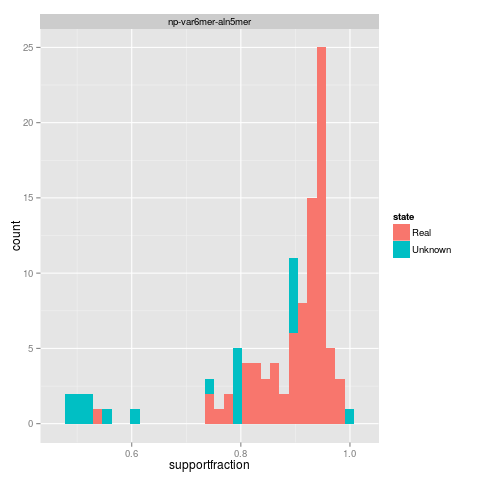

In [16]:
%%R

library(ggplot2)

stats=read.table("validation_stats.txt", header=T)
ggplot(stats, aes(x=supportfraction, fill=state)) + geom_histogram() + facet_wrap(~tag)

## Remove low depth positions from plot (depth >= 30)

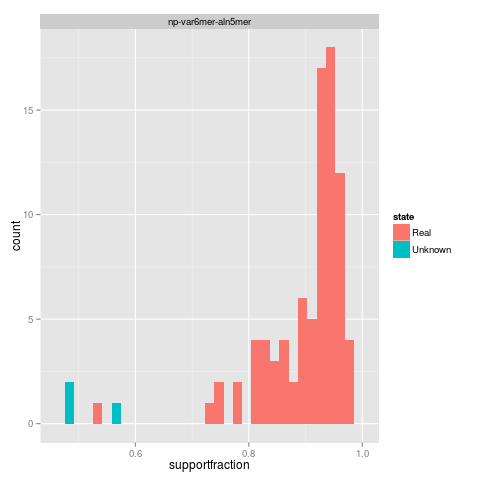

In [17]:
%%R

library(ggplot2)

stats=read.table("validation_stats.txt", header=T)
ggplot(subset(stats, supportingreads>50), aes(x=supportfraction, fill=state)) + geom_histogram(breaks=c()) + facet_wrap(~tag)

## Filter the files as per the study (depth > 30, support fraction > 0.70%, primer sequences masked)

In [32]:
!makecommands.py ../metadata/metadata.db 180_Genomes consensus | parallel -j16

+ ref_prefix=EM_079517
+ sample=076534_180Genomes_11rx
+ poretools_dir=076534_180Genomes_11rx
+ sample_tag=076534_180Genomes_11rx_hq
+ second_batch=na
+ vcftagprimersites.py all np_EM_079517_076534_180Genomes_11rx_hq.vcf
+ vcffilter.py 076534_180Genomes_11rx_hq_EM_079517_np_primer.tagged.vcf
Filtering Record(CHROM=EM_079517, POS=16622, REF=G, ALT=[A])
Filtering Record(CHROM=EM_079517, POS=16626, REF=T, ALT=[A])
Filtering Record(CHROM=EM_079517, POS=16629, REF=A, ALT=[G])
Filtering Record(CHROM=EM_079517, POS=16631, REF=A, ALT=[T])
Output 14 records
+ ref_prefix=EM_079517_mut30_2
+ sample=076534_180Genomes_11rx
+ poretools_dir=076534_180Genomes_11rx
+ sample_tag=076534_180Genomes_11rx_hq
+ second_batch=na
+ vcftagprimersites.py all np_EM_079517_mut30_2_076534_180Genomes_11rx_hq.vcf
+ vcffilter.py 076534_180Genomes_11rx_hq_EM_079517_mut30_2_np_primer.tagged.vcf
Filtering Record(CHROM=EM_079517, POS=16622, REF=G, ALT=[A])
Filtering Record(CHROM=EM_079517, POS=16626, REF=T, ALT=[A])
Filter

In [34]:
fh = open("validation_files_filtered.txt", "w")
fh.write("""076534_180Genomes_11rx	np-6mer-5meralign	../refs/EM_079517_EM_076534.mutations.txt	076534_180Genomes_11rx_hq_EM_079517_np_primer.filtered075_30.vcf
076533_180Genomes_11rx	np-6mer-5meralign	../refs/EM_079517_EM_076533.mutations.txt	076533_180Genomes_11rx_hq_EM_079517_np_primer.filtered075_30.vcf
076383_180Genomes_11rx	np-6mer-5meralign	../refs/EM_079517_EM_076383.mutations.txt	076383_180Genomes_11rx_hq_EM_079517_np_primer.filtered075_30.vcf
078416_180Genomes_11rx	np-6mer-5meralign	../refs/EM_079517_EM_078416.mutations.txt	078416_180Genomes_11rx_hq_EM_079517_np_primer.filtered075_30.vcf
076769_180Genomes_19Rx	np-6mer-5meralign	../refs/EM_079517_EM_076769.mutations.txt	076769_180Genomes_19Rx_hq_EM_079517_np_primer.filtered075_30.vcf""")
fh.close()

In [35]:
!../scripts/intersection_vcf_stats.py validation_files_filtered.txt | cut -f 1,2,5,6,7,8,9,10 | column -t 

sample                  tag                total_calls  mutations  TP    FP   FN   TPR
076534_180Genomes_11rx  np-6mer-5meralign  14           17         14.0  0.0  3.0  0.823529411765
076533_180Genomes_11rx  np-6mer-5meralign  19           19         19.0  0.0  0.0  1.0
076383_180Genomes_11rx  np-6mer-5meralign  16           17         16.0  0.0  1.0  0.941176470588
078416_180Genomes_11rx  np-6mer-5meralign  17           18         17.0  0.0  1.0  0.944444444444
076769_180Genomes_19Rx  np-6mer-5meralign  18           19         18.0  0.0  1.0  0.947368421053


# Get the 180 genome set

In [ ]:
from Bio import Entrez
Entrez.email = "n.j.loman@bham.ac.uk"     # Always tell NCBI who you are
handle = Entrez.esearch(db="nucleotide", term="carroll and hiscox and ebola", retmax=200)
record = Entrez.read(handle)
handle = Entrez.efetch(db="nucleotide", id=record["IdList"], rettype="fasta", retmode="text")
fh = open("180_Genomes_references.fasta", "w")
fh.write(handle.read())

In [ ]:
!echo "\n"  >> 180_Genomes_references.fasta 
!cat 180_Genomes_references.fasta  180_Genomes.fasta > validate_tree.fasta
!sed --in-place '/^$/d' validate_tree.fasta
!muscle3.8.31_i86linux64 -in validate_tree.fasta > validate_tree_aligned.fasta

In [ ]:
!sed --in-place 's/>.*H.sapiens-wt\//>/' validate_tree_aligned.fasta
!sed --in-place 's/>EM_079517_/>MinION_/' validate_tree_aligned.fasta
!sed --in-place 's/,//' validate_tree_aligned.fasta

In [ ]:
!grep ">" validate_tree_aligned.fasta

In [ ]:
!rm *validate_tree_aligned.raxml
!raxmlHPC-PTHREADS-SSE3 -T 32 -f a -x 12345 -p 12345 -# 100 -m GTRGAMMA -s validate_tree_aligned.fasta -n validate_tree_aligned.raxml

In [ ]:
!cat /mnt/ebola/ebov/analysis/RAxML_bipartitions.validate_tree_aligned.raxml


In [ ]:
!pip install ete2

from ete2 import Tree
t = Tree()
t.populate(20)
t.render(file_name="test.png", w=500)